In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import imutils 
import dlib
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%load_ext autotime
%matplotlib inline

In [5]:
# loading the model

detector = tf.keras.models.load_model('D:\eye detection\eye_direction.h5')
detector.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3276928   
__________

In [6]:
face_cascade=cv2.CascadeClassifier(r'D:\eye detection\haarcascade_xml_files\haarcascades\haarcascade_frontalface_default.xml')
right_eye_cascade=cv2.CascadeClassifier(r'D:\eye detection\haarcascade_xml_files\haarcascades\haarcascade_righteye_2splits.xml')
left_eye_cascade=cv2.CascadeClassifier(r'D:\eye detection\haarcascade_xml_files\haarcascades\haarcascade_lefteye_2splits.xml')

time: 112 ms


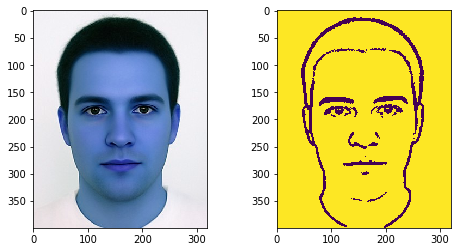

time: 840 ms


In [8]:
eye_img = cv2.imread(r'D:\eye detection\sample_image.jpg')

gray = cv2.cvtColor(eye_img,cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray,9,75,75)
gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,3)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(eye_img)
plt.subplot(1,2,2)
plt.imshow(gray)

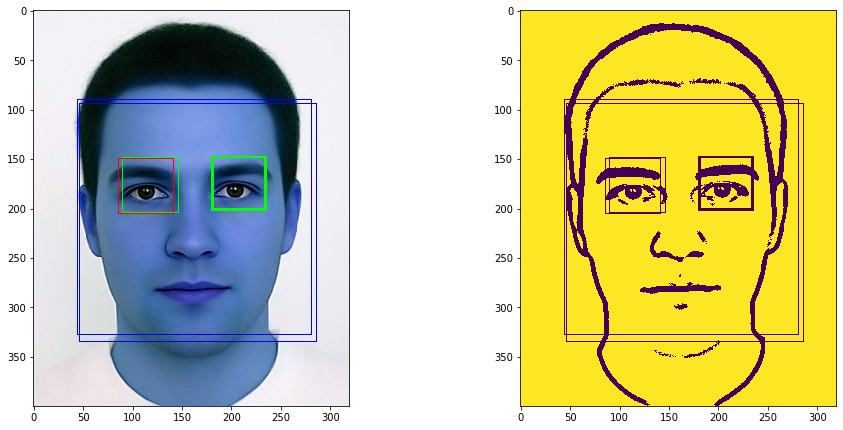

time: 1.04 s


In [74]:
faces = face_cascade.detectMultiScale(gray,1.3,6)
if faces is not None:
    for (x,y,w,h) in faces:
        roi_gray_face = gray[y:y+h, x:x+w]
        roi_color_face = eye_img[y:y+h, x:x+w]
        
        cv2.rectangle(eye_img,(x,y),(x+w,y+h),(0,0,255),1)
        cv2.rectangle(gray,(x,y),(x+w,y+h),(0,255,0),1)
        
        left_eye = left_eye_cascade.detectMultiScale(roi_gray_face)
        if left_eye is not None:
            for (ex,ey,ew,eh) in left_eye:
                roi_gray_eye = roi_gray_face[ey:ey+eh, ex:ex+ew]
                roi_color_eye = roi_color_face[ey:ey+eh, ex:ex+ew]

                cv2.rectangle(roi_gray_face,(ex,ey),(ex+ew,ey+eh),(0,255,0),1)
                cv2.rectangle(roi_color_face,(ex,ey),(ex+ew,ey+eh),(0,255,0),1)
                
        right_eye = right_eye_cascade.detectMultiScale(roi_gray_face)
        if right_eye is not None:
            for (rx,ry,rw,rh) in right_eye:
                roi_gray_eye = roi_gray_face[ry:ry+rh, rx:rx+rw]
                roi_color_eye = roi_color_face[ry:ry+rh, rx:rx+rw]

                cv2.rectangle(roi_gray_face,(rx,ry),(rx+rw,ry+rh),(0,255,0),1)
                cv2.rectangle(roi_color_face,(rx,ry),(rx+rw,ry+rh),(255,0,0),1)

 
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.imshow(eye_img)
plt.subplot(2,2,2)
plt.imshow(gray)

In [75]:
roi_color_eye.shape

(1, 51, 51, 3)

time: 8 ms


In [79]:
roi_eye = cv2.resize(roi_color_eye,(80,80),interpolation = cv2.INTER_AREA)
roi_eye = np.reshape(roi_color_eye,(1,80,80,3))
pred_cls = detector.predict_classes(roi_color_eye)

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3363: error: (-215:Assertion failed) !dsize.empty() in function 'cv::hal::resize'


time: 28 ms


In [7]:
cap = cv2.VideoCapture(0)
cv2.namedWindow('PUPIL TRACKER')
while 1:
    ret,vid = cap.read()
    vid = cv2.flip(vid,1)
    
    gray_vid = cv2.cvtColor(vid,cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.bilateralFilter(gray_vid,9,75,75)
    gray_blur = cv2.adaptiveThreshold(gray_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,3)
    
    faces = face_cascade.detectMultiScale(gray_blur,1.2,6)
    for (x,y,w,h) in faces:
        roi_gray_face = gray_vid[y+20:y+h, x:x+w]
        roi_color_face = vid[y+20:y+h, x:x+w]   
        
        rcf_zoom = cv2.resize(roi_color_face,(500,500),interpolation = cv2.INTER_AREA)
        rgf_zoom = cv2.resize(roi_gray_face,(500,500),interpolation = cv2.INTER_AREA) 
        
        left_eye = left_eye_cascade.detectMultiScale(rcf_zoom,1.2,6)
        right_eye = right_eye_cascade.detectMultiScale(rcf_zoom,1.2,6)
        
        for (lex,ley,lew,leh) in left_eye:
            roi_eye = rcf_zoom[ley:ley+leh,lex:lex+lew]
            
            cv2.rectangle(rcf_zoom,(lex,ley),(lex+lew,ley+leh),(0,255,0),1)
            cv2.rectangle(rgf_zoom,(lex,ley),(lex+lew,ley+leh),(0,255,0),1)
            
            eye_pos = cv2.resize(roi_eye,(80,80))
            eye_pos = np.array(eye_pos)
            eye_pos = eye_pos/255
            eye_img = np.reshape(eye_pos,(1,80,80,3))
            
            pred_cls = detector.predict_classes(eye_img)
    
        rgf_zoom = cv2.addWeighted(rgf_zoom,1.7,cv2.blur(rgf_zoom,(5,5),cv2.BORDER_DEFAULT),-1,0)
        
        cv2.imshow('PUPIL TRACKER',rcf_zoom)
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
            break
              
cv2.destroyAllWindows()
cap.release()

time: 30.7 s


In [106]:
print(roi_eye.shape)
print(type(roi_eye))

(119, 119, 3)
<class 'numpy.ndarray'>
Error in callback <function LineWatcher.stop at 0x0000012D51F3F158> (for post_run_cell):


AssertionError: 

In [107]:
eye_pos = cv2.resize(roi_eye,(80,80))
print(eye_pos.shape)
eye_pos = np.array(eye_pos)
eye_pos = eye_pos/255
eye_img = np.reshape(eye_pos,(1,80,80,3))
print(eye_img.shape)

(80, 80, 3)
(1, 80, 80, 3)
time: 4 ms


In [111]:
label_dict = {0:'left',1:'forward',2:'closed',3:'right'}

pred_cls = detector.predict_classes(eye_img)
print(pred_cls)

[1]
time: 100 ms
